In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle

from util import *
import scanpy.api as sc
import data_loader as dl
import scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
output_folder = './figures/figure_experimental_design'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
# data = dl.load_10x_4k()
# Nc,G,Nr,Nr_bar = sd.get_info(data)
# sc.pp.filter_genes(data,min_counts=0.1*data.shape[0])
# Nc,G,Nr_fil,Nr_bar_fil = sd.get_info(data)
# gene_list = np.array(data.var_names)


## Collect the data
dataset={}
dataset['brain_1k'] = dl.load_10x_1k() # 1k brain cells 
dataset['brain_2k'] = dl.load_10x_2k() # 2k brain cells 
dataset['brain_9k'] = dl.load_10x_9k() # 9k brain cells 
# dataset['brain_1.3m'] = dl.load_10x_1_3mil() # 1.3 million brain cells 
dataset['pbmc_4k'] = dl.load_10x_4k() # 4k PBMC cells
dataset['pbmc_8k'] = dl.load_10x_8k() # 8k PBMC cells 
dataset['pbmc_68k'] = dl.load_10x_68k() # 68k PBMC cells 
dataname_list = list(dataset.keys())

data_param_dic = {}
for dname in dataset.keys():
    data = dataset[dname]
#     data = sc.pp.filter_genes(data,min_counts=0.01*data.shape[0],copy=True)
    Nc,G,Nr,Nr_bar = sd.get_info(data)
    data_param_dic[dname] = [Nc,G,Nr,Nr_bar]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=931, G=27998, Nr=11531.54, Nr_bar=0.41
## Nc=2022, G=27998, Nr=7590.87, Nr_bar=0.27
## Nc=9128, G=27998, Nr=7346.04, Nr_bar=0.26
## Nc=4340, G=33694, Nr=4349.04, Nr_bar=0.13
## Nc=8381, G=33694, Nr=4639.05, Nr_bar=0.14
## Nc=68579, G=32738, Nr=1369.83, Nr_bar=0.04


In [68]:
def get_MSE(M,Nr,Nc,size_factor):
    precision = 1e-8
    idx_bad = np.zeros([M.shape[1]],dtype=bool)
    B = Nr*Nc
    
    reci1 = np.mean(1/size_factor)
    reci2 = np.mean(1/size_factor**2)
    
    MSE = (M[3]-M[1]**2)/Nc + 4*M[2]/B*reci1 + 2*M[1]/B/Nr*reci2
    idx_bad[MSE<=0] = True
    #print(MSE)
    MSE = MSE.clip(min=precision/Nr**4)
    idx_bad[M[1]<=0] = True
    RMSE = MSE/M[1].clip(min=precision/Nr**2)**2
    MSE[idx_bad] = -1
    RMSE[idx_bad] = -1
    return MSE,RMSE

def get_error_grid(dataset,ref_data_name='pbmc_4k',n_top_gene=500):
    size_factor = sd.dd_size_factor(dataset[ref_data_name],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(dataset[ref_data_name],size_factor=size_factor,verbose=False,k=4,\
                                Nr=data_param_dic[ref_data_name][2])
    mean_count = np.array(dataset[ref_data_name].X.mean(axis=0)).reshape(-1)
    sort_idx = np.argsort(mean_count)[::-1]

    Nr_list = 10**np.linspace(3,4.5,10)
    Nc_list = 10**np.linspace(3,5.5,10)

    error_list = np.zeros([10,10])

    for i_Nr_,Nr_ in enumerate(Nr_list):
        for i_Nc_,Nc_ in enumerate(Nc_list):       
            MSE,RMSE = get_MSE(M_dd,Nr_,Nc_,size_factor)
            temp = RMSE[sort_idx[0:n_top_gene]]
            temp = temp[temp!=-1]
#             print(temp.shape[0])
            error_list[i_Nc_,i_Nr_]=np.log10(np.mean(temp))
    return Nc_list,Nr_list,error_list

def plot_err_contour(Nc_list,Nr_list,error_list,dataset,opt='pbmc',\
                     output_folder='',figname='',title=''):
    plt.figure(figsize=[7,5])
    CS = plt.contour(np.log10(Nr_list),np.log10(Nc_list),error_list,levels=[-5,-4,-3,-2,-1,0])
    for dname in data_param_dic.keys():
        if opt in dname:
            Nc_,G,Nr_,Nr_bar = data_param_dic[dname]
            plt.scatter([np.log10(Nr_)],[np.log10(Nc_)],marker='^',color='red')
            plt.annotate(dname,[np.log10(Nr_),np.log10(Nc_)])
    plt.clabel(CS)
    plt.xlabel('Nr')
    plt.ylabel('Nc')
    
    Nr_list = np.array([1000,3000,10000,30000])
    Nr_list_str = ['1k','3k','10k','30k']
    Nc_list = np.array([1000,3000,10000,30000,100000])
    Nc_list_str = ['1k','3k','10k','30k','100k']
    
    plt.xticks(np.log10(Nr_list),Nr_list_str)
    plt.yticks(np.log10(Nc_list),Nc_list_str)
    plt.grid(ls='--')
    plt.title(title)
    plt.savefig(output_folder+'/'+figname+'.png')
    plt.savefig(output_folder+'/'+figname+'.pdf')
    plt.show()

# PBMC dataset

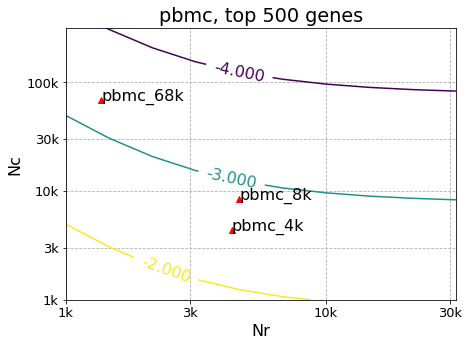

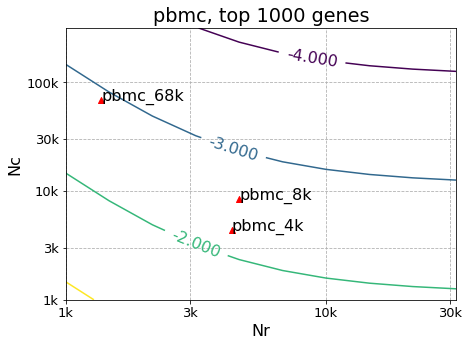

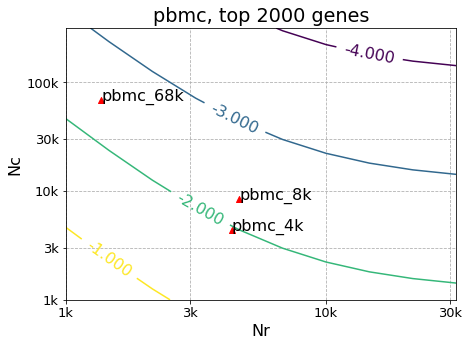

In [69]:
ref_data_name='pbmc_4k'
n_top_gene=2000
for n_top_gene in [500,1000,2000]:
    figname = 'pbmc_error_contour'+'_'+ref_data_name+'_topgene%d'%n_top_gene
    title = 'pbmc, top %d genes'%n_top_gene

    Nc_list,Nr_list,error_list = get_error_grid(dataset,ref_data_name=ref_data_name,n_top_gene=n_top_gene)
    plot_err_contour(Nc_list,Nr_list,error_list,dataset,opt='pbmc',\
                     output_folder=output_folder,figname=figname,title=title)

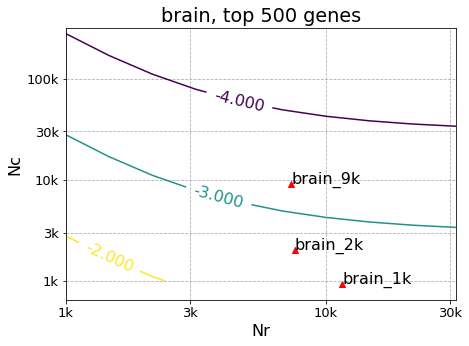

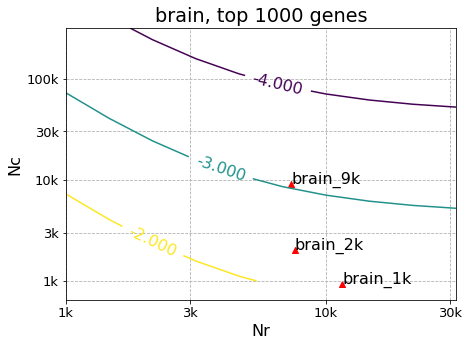

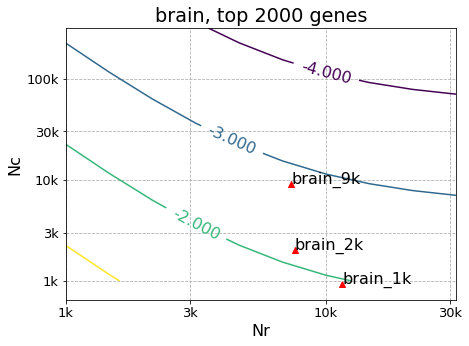

In [70]:
ref_data_name='brain_9k'
n_top_gene=2000
for n_top_gene in [500,1000,2000]:
    figname = 'brain_error_contour'+'_'+ref_data_name+'_topgene%d'%n_top_gene
    title = 'brain, top %d genes'%n_top_gene

    Nc_list,Nr_list,error_list = get_error_grid(dataset,ref_data_name=ref_data_name,n_top_gene=n_top_gene)
    plot_err_contour(Nc_list,Nr_list,error_list,dataset,opt='brain',\
                     output_folder=output_folder,figname=figname,title=title)

# Old code

In [497]:
ref_data = 'pbmc_4k'
size_factor = sd.dd_size_factor(dataset[ref_data],verbose=False)
M_ml,M_dd = sd.dd_1d_moment(dataset[ref_data],size_factor=size_factor,verbose=False,k=4,Nr=data_param_dic[ref_data][2])
print(M_dd[0,0:5])
mean_count = np.array(dataset[ref_data].X.mean(axis=0)).reshape(-1)
sort_idx = np.argsort(mean_count)[::-1]

Nr_list = []
Nc_list = []
Nr_list = 10**np.linspace(2,4,10)
Nc_list = 10**np.linspace(2,6,10)

error_list_500 = np.zeros([10,10])
error_list_1000 = np.zeros([10,10])

for i_Nr_,Nr_ in enumerate(Nr_list):
    for i_Nc_,Nc_ in enumerate(Nc_list):       
        MSE,RMSE = get_MSE(M_dd,Nr_,Nc_,size_factor)
        temp = RMSE[sort_idx[0:500]]
        temp = temp[temp!=-1]
        error_list_500[i_Nc_,i_Nr_]=np.log10(np.mean(temp))
        temp = RMSE[sort_idx[0:1000]]
        temp = temp[temp!=-1]
        error_list_1000[i_Nc_,i_Nr_]=np.log10(np.mean(temp))



[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.62938623e-07
 1.17638722e-07]


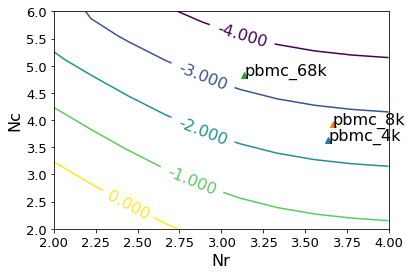

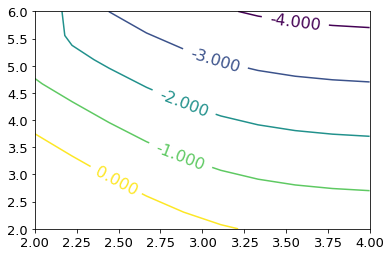

In [484]:
plt.figure()
CS = plt.contour(np.log10(Nr_list),np.log10(Nc_list),error_list_500,levels=[-5,-4,-3,-2,-1,0])
for dname in data_param_dic.keys():
    if 'pbmc' in dname:
        Nc_,G,Nr_,Nr_bar = data_param_dic[dname]
        plt.scatter([np.log10(Nr_)],[np.log10(Nc_)],marker='^')
        plt.annotate(dname,[np.log10(Nr_),np.log10(Nc_)])
plt.clabel(CS)
plt.xlabel('Nr')
plt.ylabel('Nc')
plt.show()



plt.figure()
CS = plt.contour(np.log10(Nr_list),np.log10(Nc_list),error_list_1000,levels=[-4,-3,-2,-1,0])
plt.clabel(CS)
plt.show()

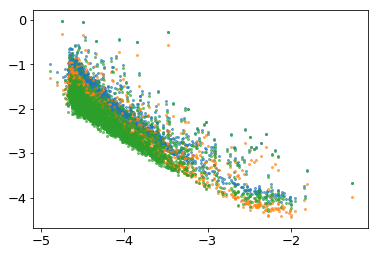

In [470]:
plt.figure()
MSE,RMSE = get_MSE(M_dd,Nr,Nc,size_factor)
plt.scatter(np.log10(M_dd[0]),np.log10(RMSE),alpha=0.6,s=4)
MSE,RMSE = get_MSE(M_dd,1*Nr,2*Nc,size_factor)
plt.scatter(np.log10(M_dd[0]),np.log10(RMSE),alpha=0.6,s=4)
MSE,RMSE = get_MSE(M_dd,2*Nr,Nc,size_factor)
plt.scatter(np.log10(M_dd[0]),np.log10(RMSE),alpha=0.6,s=4)
plt.show()

# A validation experiment

In [272]:
size_factor = sd.dd_size_factor(data,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data,size_factor=size_factor,verbose=False,k=4,Nr_normalize=True)

n_rep = 50
Nc_rate_list = [0.1,0.3,0.5,0.7,0.9]

err = np.zeros([n_rep,len(Nc_rate_list),G])
rerr = np.zeros([n_rep,len(Nc_rate_list),G])
t_err = np.zeros([len(Nc_rate_list),G])
t_rerr = np.zeros([len(Nc_rate_list),G])

for i_Nc,Nc_rate in enumerate(Nc_rate_list):    
    for i_rep in range(n_rep):      
        data_subsample = sd.subsample_anndata(data,Nr,int(Nc*Nc_rate),random_state=i_rep,verbose=False)
        size_factor_ = sd.dd_size_factor(data_subsample,verbose=False)
        M_ml_sub,M_dd_sub = sd.dd_1d_moment(data_subsample,size_factor=size_factor_,\
                                            verbose=False,k=4,Nr_normalize=True)    
        err[i_rep,i_Nc,:] = (M_dd_sub[1]-M_dd[1])**2
        rerr[i_rep,i_Nc,:] = (M_dd_sub[1]-M_dd[1])**2/M_dd[1]**2
    
    MSE,RMSE = get_MSE(M_dd,Nr,int(Nc*Nc_rate),size_factor)
    t_err[i_Nc] = np.log10(MSE)
    t_rerr[i_Nc] = RMSE

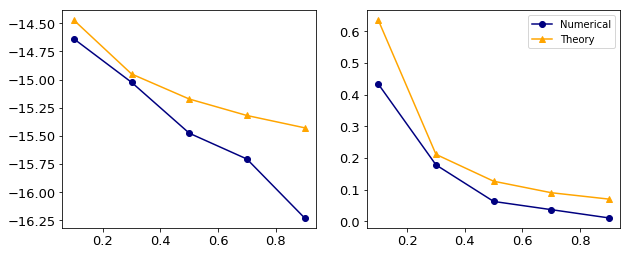

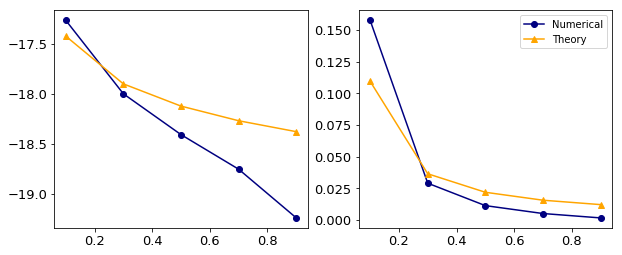

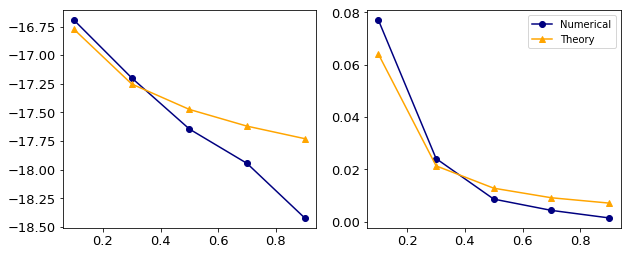

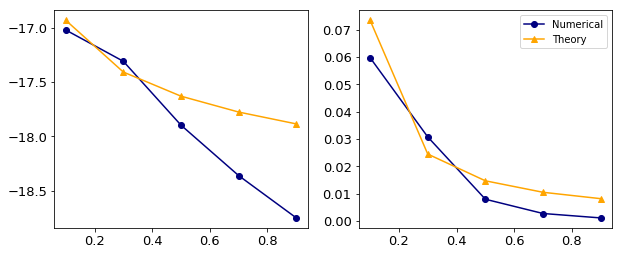

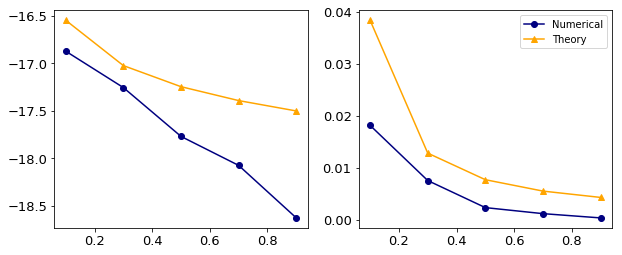

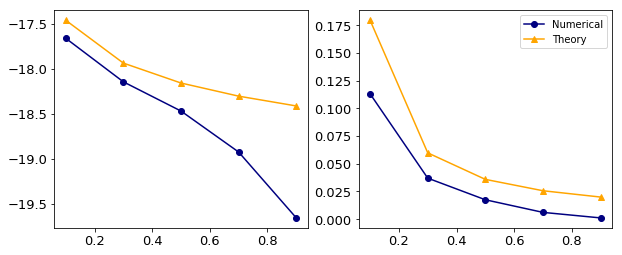

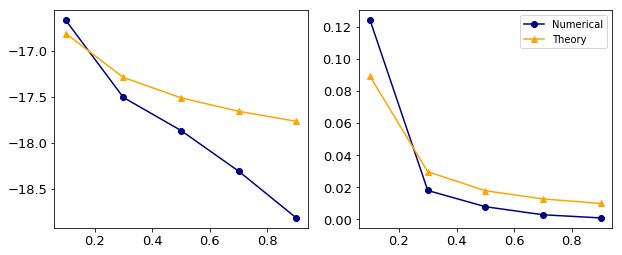

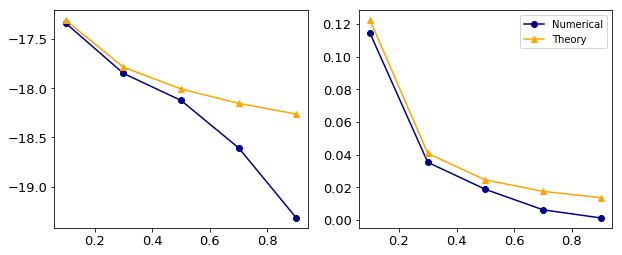

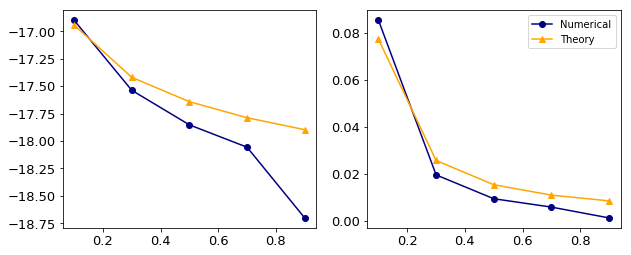

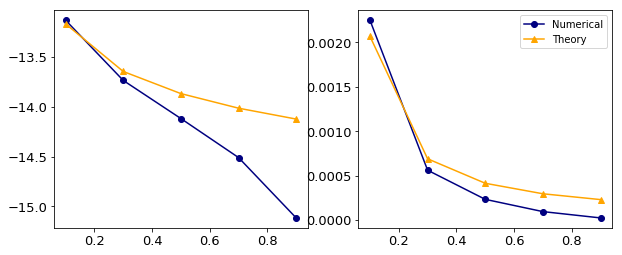

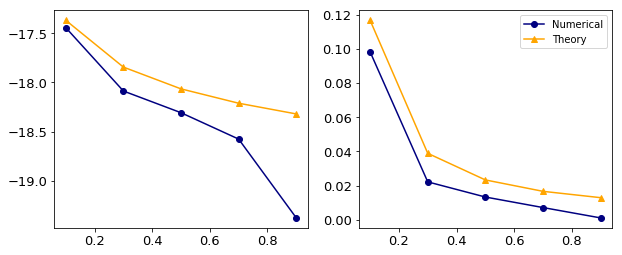

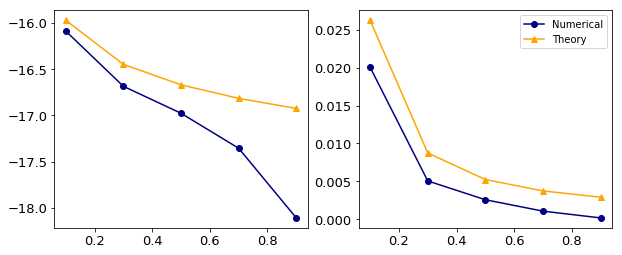

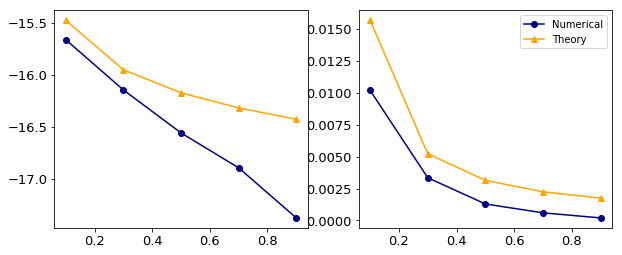

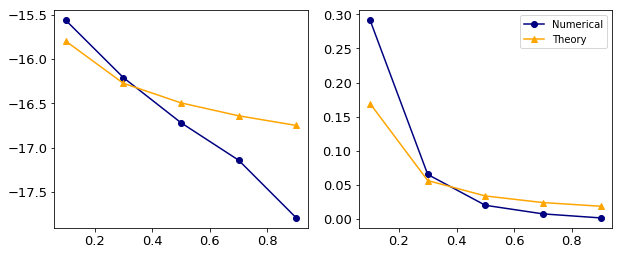

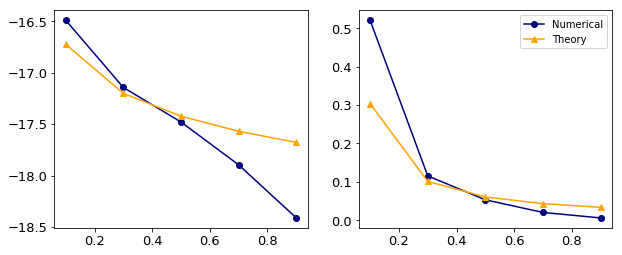

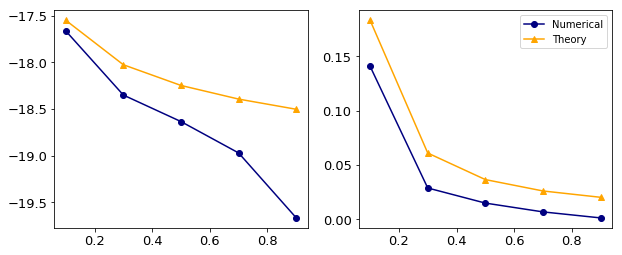

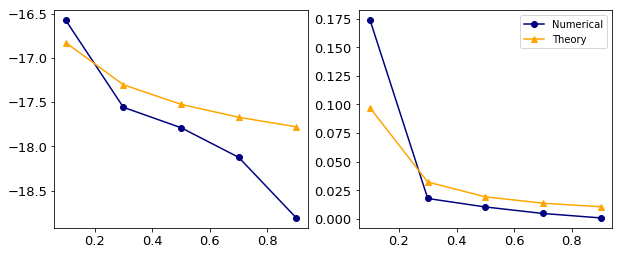

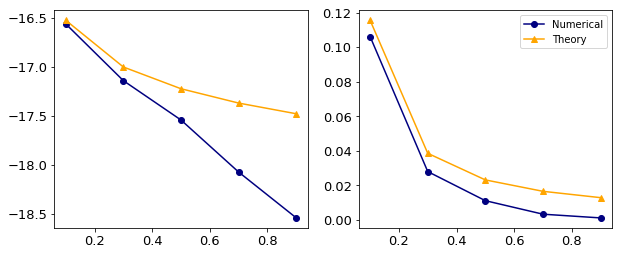

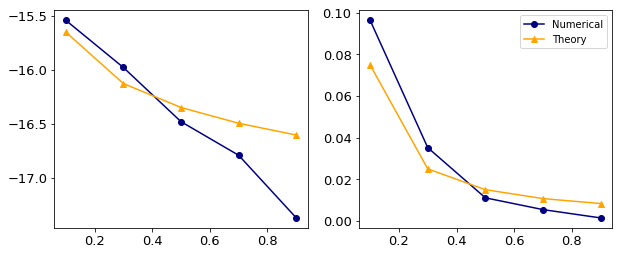

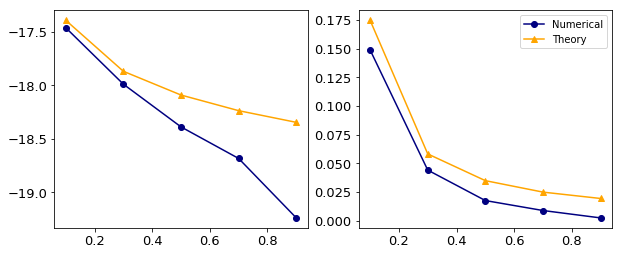

In [278]:
plot_list = np.arange(20)

for i_gene,gene in enumerate(plot_list):
    plt.figure(figsize=[10,4])
    plt.subplot(121)
    plt.plot(Nc_rate_list,np.log10(err[:,:,gene].mean(axis=0)),marker='o',color='navy',label='Numerical')
    plt.plot(Nc_rate_list,t_err[:,gene],marker='^',color='orange',label='Theory')
    plt.subplot(122)
    plt.plot(Nc_rate_list,(rerr[:,:,gene].mean(axis=0)),marker='o',color='navy',label='Numerical')
    plt.plot(Nc_rate_list,t_rerr[:,gene],marker='^',color='orange',label='Theory')
    plt.legend()
    plt.show()